In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/GitHub/dynamics-simulation-16-715/lecture-notebooks/Lecture 17/Project.toml`


In [85]:
using LinearAlgebra
using OrdinaryDiffEq
using ForwardDiff
using Plots

In [86]:
#Parameters
g = 9.81
m = 1.0 #link mass
ℓ = 1.0 #link length
J = 0.5*m*ℓ*ℓ #link inertia

0.5

In [87]:
function kinematics(q)
    
    r = [0.5*ℓ*sin(q[1]); -0.5*ℓ*cos(q[1]); q[1]; 
         ℓ*sin(q[1]) + 0.5*ℓ*sin(q[1]+q[2]);
         -ℓ*cos(q[1]) - 0.5*ℓ*cos(q[1]+q[2]);
         q[1]+q[2]]
end

kinematics (generic function with 1 method)

In [88]:
function potential(q)
    
    r = kinematics(q)
    y1 = r[2]
    y2 = r[5]
    
    U = m*g*y1 + m*g*y2
end

potential (generic function with 1 method)

In [89]:
function kinetic(q,q̇)
    
    K = ForwardDiff.jacobian(kinematics,q)
    ṙ = K*q̇
    
    T = 0.5*ṙ'*Diagonal([m; m; J; m; m; J])*ṙ
end

kinetic (generic function with 1 method)

In [90]:
function Lagrangian(q,q̇)
    return kinetic(q,q̇) - potential(q)
end

Lagrangian (generic function with 1 method)

In [91]:
function D1L(q,q̇)
    return ForwardDiff.gradient(dq->Lagrangian(dq,q̇),q)
end

function D2L(q,q̇)
    return ForwardDiff.gradient(dq̇->Lagrangian(q,dq̇),q̇)
end

function D2D2L(q,q̇)
    return ForwardDiff.jacobian(dq̇->D2L(q,dq̇),q̇)
end

function D1D2L(q,q̇)
    return ForwardDiff.jacobian(dq->D2L(dq,q̇),q)
end

D1D2L (generic function with 1 method)

In [92]:
function dynamics(x,τ)
    q = x[1:2]
    q̇ = x[3:4]
    
    #Forced Euler-Lagrange Equation
    q̈ = D2D2L(q,q̇)\(D1L(q,q̇) - D1D2L(q,q̇)*q̇ + τ)
    
    ẋ = [q̇; q̈]
end

dynamics (generic function with 2 methods)

In [98]:
function controller(x)
    q = x[1:2]
    q̇ = x[3:4]
    
    kp = 100.0
    kd = 10.0
    
    u = -kp*(q-[pi; 0.0]) - kd*q̇
end

controller (generic function with 1 method)

In [99]:
#Simulate
x0 = randn(4)

function f(x,p,t)
    #u = zeros(2)
    u = controller(x)
    dynamics(x, u)
end

tspan = (0.0,10.0)
prob = ODEProblem(f,x0,tspan)
sol = solve(prob,Tsit5(),abstol=1e-6,reltol=1e-6);

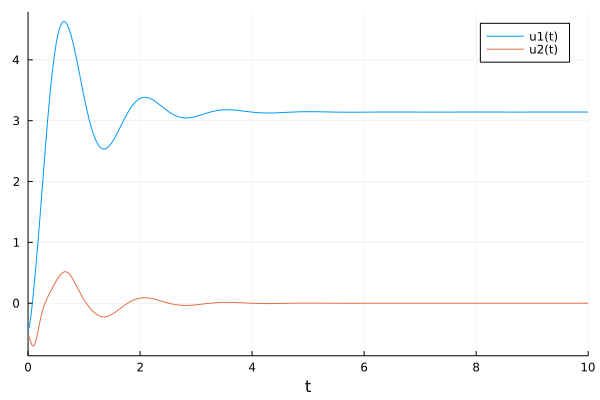

In [100]:
plot(sol,vars=(0,1))
plot!(sol,vars=(0,2))

In [101]:
function y(q)
    #We're going to apply a force at the end of the 2nd link
    return ℓ*sin(q[1]) + ℓ*sin(q[1]+q[2])
end

function Y(q)
    ForwardDiff.gradient(dq->y(dq),q)'
end

Y (generic function with 1 method)

In [102]:
function dynamics(x,F)
    q = x[1:2]
    q̇ = x[3:4]
    
    #damping constant
    c = 10.0
    
    #Forced Euler-Lagrange Equation
    q̈ = D2D2L(q,q̇)\(D1L(q,q̇) - D1D2L(q,q̇)*q̇ - c*q̇ + Y(q)'*F)
    
    ẋ = [q̇; q̈]
end

dynamics (generic function with 2 methods)

In [109]:
#Simulate
x0 = zeros(4)

function f(x,p,t)
    F = 100.0
    dynamics(x, F)
end

tspan = (0.0,10.0)
prob = ODEProblem(f,x0,tspan)
sol = solve(prob,Tsit5(),abstol=1e-6,reltol=1e-6);

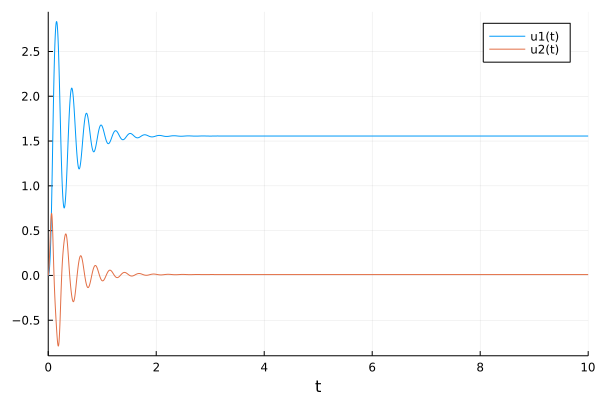

In [110]:
plot(sol,vars=(0,1))
plot!(sol,vars=(0,2))